In [1]:
%cd libspn
import libspn as spn
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as scp

/content/libspn
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# Type of input distributions for dense generator
input_dist = spn.DenseSPNGeneratorLayerNodes.InputDist.RAW

num_decomps=2
num_subsets=3
num_mixtures=2

# Number of input mixtures for dense generator
num_input_mixtures = 2

# Additive smoothing during learning
additive_smoothing=100
min_additive_smoothing=1
smoothing_decay=0.2

# Weight initialization
# weight_init_value = 1
weight_init_value = spn.ValueType.RANDOM_UNIFORM(1.0, 1.0)

# Type of inference during upward pass of learning
value_inference_type = spn.InferenceType.MARGINAL

In [3]:
datasets = tf.contrib.learn.datasets.mnist.read_data_sets("/home/jos/datasets/mnist")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /home/jos/datasets/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /home/jos/datasets/mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /home/jos/datasets/mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /home/jos/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
def process_set(data):
#     threshold = 20
    images = np.reshape(data, (-1, 28,28))
    resized=[]
    for i in range(images.shape[0]):
        resized.append((scp.misc.imresize(images[i, :, :], 0.5).ravel()))
    images=np.vstack(resized)
    return images / 255.

In [5]:
def show_mnist(img):
    img=np.reshape(img, (14,14))
    plt.imshow((img * 255.).astype(np.int32), interpolation='none', cmap="gray")
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


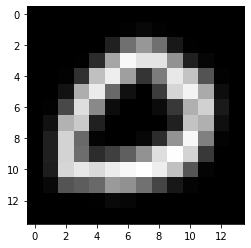

In [6]:
train_images = process_set(datasets.train.images)
test_images = process_set(datasets.test.images)
train_labels = datasets.train.labels
test_labels = datasets.test.labels
validation_labels = datasets.validation.labels

show_mnist(train_images[19])

In [7]:
train_images_0 = train_images[train_labels==0]
train_images_1 = train_images[train_labels==1]
test_images_0 = test_images[test_labels==0]
test_images_1 = test_images[test_labels==1]

(5444, 196)


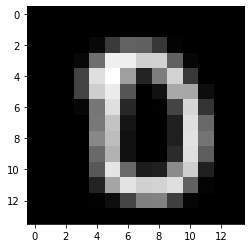

(6179, 196)


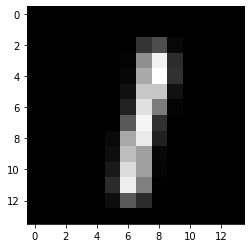

(980, 196)


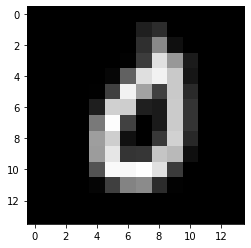

(1135, 196)


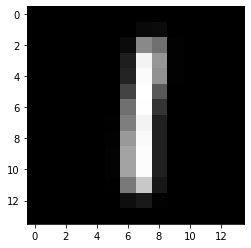

In [8]:
print(train_images_0.shape)
show_mnist(train_images_0[334])
print(train_images_1.shape)
show_mnist(train_images_1[22])
print(test_images_0.shape)
show_mnist(test_images_0[334])
print(test_images_1.shape)
show_mnist(test_images_1[22])

In [9]:
mean_init = np.tile(np.reshape(np.linspace(0, 1, 4), (1, 4)), (196, 1))
tf.reset_default_graph()
train_set = np.concatenate([train_images_0, train_images_1], 0)
gauss_quantiles = spn.GaussianLeaf(num_vars=196, num_components=4, mean_init=mean_init, variance_init=1e-2, total_counts_init=5 * len(train_set),
                                   learn_dist_params=True, train_var=True, train_mean=True, learn_scale=True, 
                                   use_prior=True, min_stddev=1e-8)
# gauss_quantiles.learn_from_data(train_images)
dense_gen = spn.DenseSPNGeneratorLayerNodes(num_decomps=num_decomps, num_subsets=num_subsets, num_mixtures=num_mixtures, 
                                            input_dist=input_dist, num_input_mixtures=num_input_mixtures,
                                            node_type=spn.DenseSPNGeneratorLayerNodes.NodeType.LAYER)
root0 = dense_gen.generate(gauss_quantiles)
root1 = dense_gen.generate(gauss_quantiles)
root = spn.Sum(root0, root1)
spn.generate_weights(root, init_value=weight_init_value)
latent = root.generate_ivs()
print(root.get_num_nodes())

34


In [10]:
additive_smoothing_var = tf.Variable(additive_smoothing, dtype=spn.conf.dtype)
learning = spn.EMLearning(root, log=True, value_inference_type = value_inference_type,
                          use_unweighted=True, initial_accum_value=5 * len(train_set))
init_weights = spn.initialize_weights(root)
reset_accumulators = learning.reset_accumulators()
accumulate_updates = learning.accumulate_updates()
update_spn = learning.update_spn()
train_likelihood=learning.value.values[root]
avg_train_likelihood = tf.reduce_mean(train_likelihood)

In [11]:
sess=None #https://github.com/whsu/spn/tree/master/spn
from tqdm import tqdm_notebook
from sklearn.utils import shuffle

writer = tf.summary.FileWriter("tflogs_mnist_continuous")

summarize_mean = tf.summary.histogram("GaussianLeafMeans", gauss_quantiles.mean_variable)
summarize_variance = tf.summary.histogram("GaussianLeafVariances", gauss_quantiles.variance_variable)

# weights = tf.get_collection('spn_weights')
# summarize_weights = tf.summary.histogram("Weights", tf.concat(weights, axis=0))
# weight_maxes = [tf.reduce_max(w) for w in weights]
# weight_dominances = [(tf.reduce_sum(w) - m) / (m + 1e-10) for w, m in zip(weights, weight_maxes)]
# weight_dom = tf.summary.histogram("WeightDominance", tf.stack(weight_dominances))
# sparseness = tf.summary.scalar("SparsenessMixtureCounts", tf.reduce_mean(
#     tf.cast(tf.equal(learning._mpe_path.counts[gauss_quantiles], 0), tf.float32)))
merged = tf.summary.merge([summarize_mean, summarize_variance])
train_set = np.concatenate([train_images_0, train_images_1], 0)
train_labels = np.concatenate([np.ones((train_images_0.shape[0]))*0, 
                               np.ones((train_images_1.shape[0]))*1])
train_labels=np.reshape(train_labels, (-1, 1))

if sess is not None:
    sess.close()

sess = tf.Session()

sess.run(init_weights)
sess.run(reset_accumulators)

num_batches=64
batch_size = train_set.shape[0] // num_batches
prev_likelihood = 100
likelihood = 0
epoch = 0

accumulators = [node.accum for node in learning._gaussian_leaf_nodes]
sum_data = [node.sum_data for node in learning._gaussian_leaf_nodes]
sum_data_squared = [node.sum_data_squared for node in learning._gaussian_leaf_nodes]

mean_history = []
variance_history = []

while abs(prev_likelihood - likelihood)>5:
    prev_likelihood=likelihood
    likelihoods = []
    pbar = tqdm_notebook(range(num_batches))
    train_set, train_labels = shuffle(train_set, train_labels)
    writer.add_summary(sess.run(merged), epoch)
    mn, vr = sess.run([gauss_quantiles.mean_variable, gauss_quantiles.variance_variable])
    mean_history.append(mn)
    variance_history.append(vr)
    for batch in pbar:
        start = (batch)*batch_size
        stop = (batch+1)*batch_size
#         print("EPOCH", epoch, "BATCH", batch, "SAMPLES", start, stop)
        # Adjust smoothing
        ads=max(np.exp(-epoch*smoothing_decay)*additive_smoothing, min_additive_smoothing)
        sess.run(additive_smoothing_var.assign(ads))
#         print("Smoothing: ", sess.run(additive_smoothing_var)) 
        # Run accumulate_updates
        train_likelihoods_arr, avg_train_likelihood_val, _ = \
                sess.run([train_likelihood, avg_train_likelihood, accumulate_updates],
                        feed_dict={gauss_quantiles: train_set[start:stop],
                                   latent: train_labels[start:stop]})
        # Print avg likelihood of this batch data on previous batch weights
#         print("Avg likelihood (this batch data on previous weights): %s" % (avg_train_likelihood_val))
        pbar.set_description("Lh {}".format(avg_train_likelihood_val))
        likelihoods.append(avg_train_likelihood_val)
    sess.run(update_spn)
    
    
    likelihood = sum(likelihoods) / len(likelihoods)
    print("Avg likelihood: %s" % (likelihood))
    epoch+=1
#     sess.run(reset_accumulators)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Avg likelihood: -18.497937560081482



Avg likelihood: 83.57394099235535



Avg likelihood: 111.9658625125885



Avg likelihood: 130.41731917858124



Avg likelihood: 144.63713002204895



Avg likelihood: 156.6753373146057



Avg likelihood: 167.25912594795227



Avg likelihood: 177.0641233921051



Avg likelihood: 186.03742742538452



Avg likelihood: 194.4472200870514



Avg likelihood: 202.42211389541626



Avg likelihood: 209.98631238937378



Avg likelihood: 217.11577367782593



Avg likelihood: 223.9074625968933



Avg likelihood: 230.34188532829285



Avg likelihood: 236.57341980934143



Avg likelihood: 242.53007316589355



Avg likelihood: 248.30503249168396



Avg likelihood: 253.7370445728302



Avg likelihood: 258.9427535533905



Avg likelihood: 264.0994002819061



Avg likelihood: 268.9771571159363


In [12]:
mpe_state_gen = spn.MPEState(log=True, value_inference_type=spn.InferenceType.MPE)
mpe_gauss_quantiles, mpe_latent = mpe_state_gen.get_state(root, gauss_quantiles, latent)
no_evidence = np.zeros((1, 14 * 14)).astype(np.bool) 


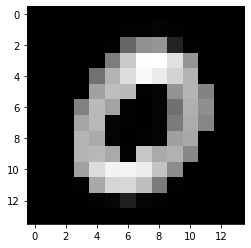

[[0]]


In [13]:
mpe_gauss_val, mpe_latent_val = sess.run(
    [mpe_gauss_quantiles, mpe_latent], feed_dict={gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[0]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

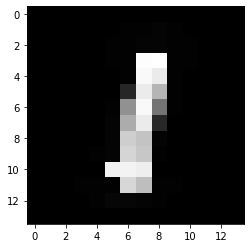

[[1]]


In [14]:
mpe_gauss_val, mpe_latent_val = sess.run(
    [mpe_gauss_quantiles, mpe_latent], feed_dict={gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[1]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor relea

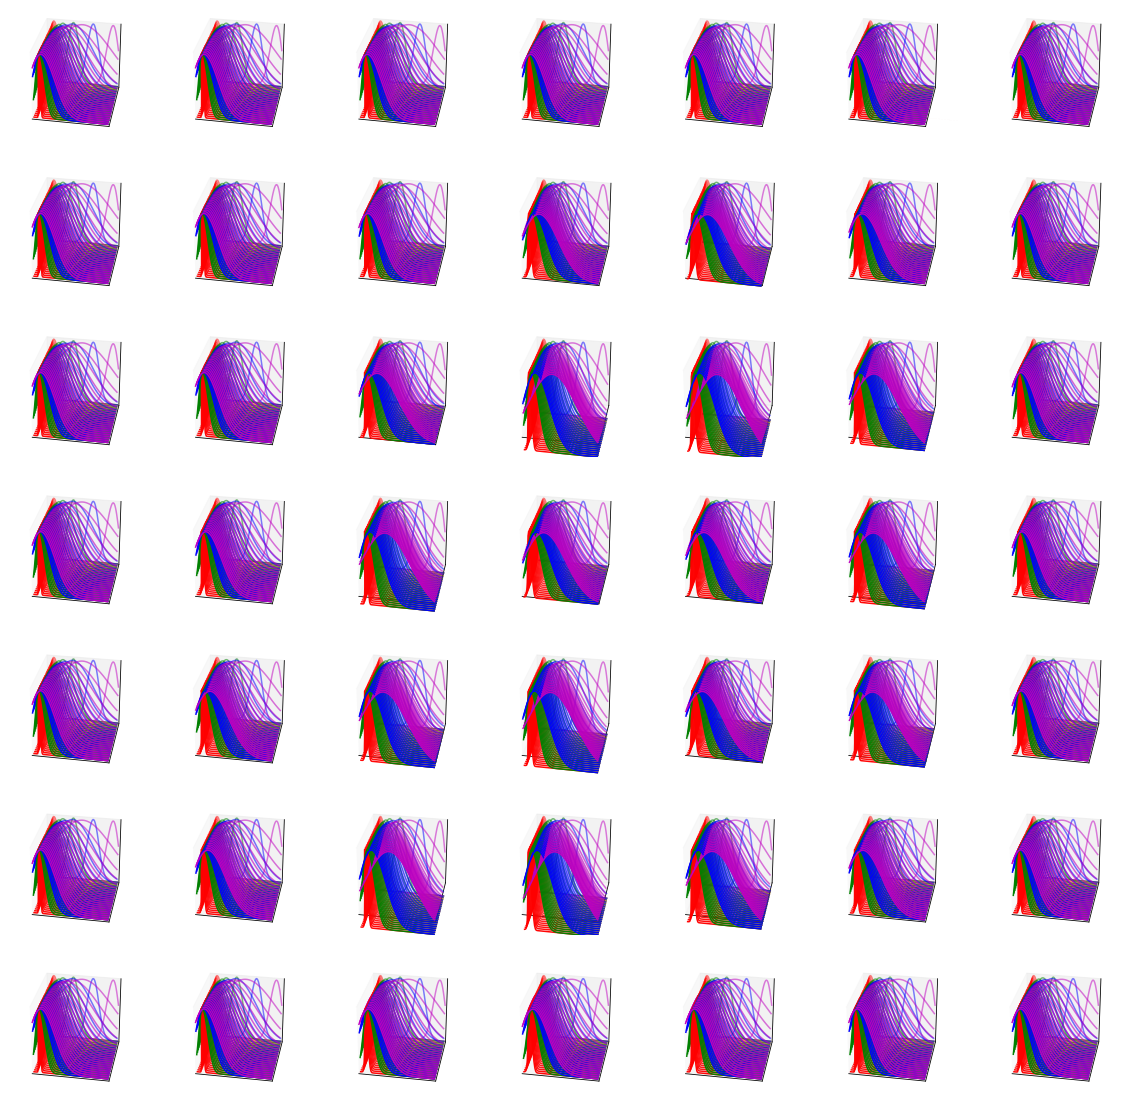

In [15]:

%matplotlib inline
# %autoreload
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpl_toolkits.mplot3d.axes3d import Axes3D
nrows, ncols = 8, 8
fig, axes = plt.subplots(nrows=7, ncols=7, subplot_kw={"projection": "3d"})
fig.set_size_inches((20, 20))

colors = ['r', 'g', 'b', 'm']

for row in range(0, 14, 2):
    for col in range(0, 14, 2):
        var_index = row * 14 + col  #, mixture_index = np.random.randint(14 * 14), np.random.randint(2)
        length = len(mean_history)
        minx, maxx, miny, maxy, minz, maxz = np.inf, -np.inf, np.inf, -np.inf, np.inf, -np.inf
        
        r, c = row // 2, col // 2
        
        for t in range(length):
            for mixture_index in range(4):
                mu, sigma = mean_history[t][var_index, mixture_index], variance_history[t][var_index, mixture_index]
                std = np.sqrt(sigma)
                x = np.linspace(-0.1, 1.1, 100)
                z = stats.norm(loc=mu, scale=std).pdf(x)
                z /= z.max()
                y = 1 - np.ones(x.shape) * t / length
                minx = min(minx, x.min())
                miny = min(miny, y.min())
                maxx = max(maxx, x.max())
                maxy = max(maxy, y.max())
                minz = min(maxz, z.min())
                maxz = max(maxz, z.max())
                
                axes[r][c].plot(x, y, z, '{}-'.format(colors[mixture_index]), alpha=(t + length) / (length * 2))
        axes[r][c].set_xticks([], [])
        axes[r][c].set_yticks([], [])
        axes[r][c].set_zticks([], [])
        
        axes[r][c].set_xlim([-.1, 1.1])
        axes[r][c].set_ylim([miny, maxy])
        axes[r][c].set_zlim([minz, maxz])
        axes[r][c].view_init(30, -80)
plt.savefig("gauss_4components_equidistant_means_var1e-2_5lendat_offline.png")